In [41]:
#kaggle santander满意度预测

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.metrics import roc_auc_score,roc_curve
from sklearn.model_selection import StratifiedKFold

In [42]:
traindata = pd.read_csv('train.csv')
testdata = pd.read_csv('test.csv')

In [43]:
#先看一下数据的基本情况，train和test数据都是20万行，有201个变量（train数据中多的一列是target目标变量）
traindata.shape


(200000, 202)

In [44]:
testdata.shape

(200000, 201)

In [45]:
traindata.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [46]:
#特征变量列
features = [c for c in traindata.columns if c not in ['ID_code','target']]

In [47]:
#查看各变量的缺失情况,可以看到各变量都没有缺失值
traindata.isnull().sum(axis=0).sort_values(ascending=False)
testdata.isnull().sum(axis=0).sort_values(ascending=False)

var_199    0
var_61     0
var_71     0
var_70     0
var_69     0
var_68     0
var_67     0
var_66     0
var_65     0
var_64     0
var_63     0
var_62     0
var_60     0
var_98     0
var_59     0
var_58     0
var_57     0
var_56     0
var_55     0
var_54     0
var_53     0
var_52     0
var_51     0
var_50     0
var_72     0
var_73     0
var_74     0
var_75     0
var_96     0
var_95     0
          ..
var_104    0
var_103    0
var_102    0
var_101    0
var_122    0
var_124    0
var_147    0
var_125    0
var_146    0
var_145    0
var_144    0
var_143    0
var_142    0
var_141    0
var_140    0
var_139    0
var_138    0
var_137    0
var_136    0
var_135    0
var_134    0
var_133    0
var_132    0
var_131    0
var_130    0
var_129    0
var_128    0
var_127    0
var_126    0
ID_code    0
Length: 201, dtype: int64

In [48]:
#features都是连续变量
#查看traindata和testdata的数据分布情况
traindata.describe()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,0.100490,10.679914,-1.627622,10.715192,6.796529,11.078333,-5.065317,5.408949,16.545850,0.284162,...,3.234440,7.438408,1.927839,3.331774,17.993784,-0.142088,2.303335,8.908158,15.870720,-3.326537
std,0.300653,3.040051,4.050044,2.640894,2.043319,1.623150,7.863267,0.866607,3.418076,3.332634,...,4.559922,3.023272,1.478423,3.992030,3.135162,1.429372,5.454369,0.921625,3.010945,10.438015
min,0.000000,0.408400,-15.043400,2.117100,-0.040200,5.074800,-32.562600,2.347300,5.349700,-10.505500,...,-14.093300,-2.691700,-3.814500,-11.783400,8.694400,-5.261000,-14.209600,5.960600,6.299300,-38.852800
25%,0.000000,8.453850,-4.740025,8.722475,5.254075,9.883175,-11.200350,4.767700,13.943800,-2.317800,...,-0.058825,5.157400,0.889775,0.584600,15.629800,-1.170700,-1.946925,8.252800,13.829700,-11.208475
50%,0.000000,10.524750,-1.608050,10.580000,6.825000,11.108250,-4.833150,5.385100,16.456800,0.393700,...,3.203600,7.347750,1.901300,3.396350,17.957950,-0.172700,2.408900,8.888200,15.934050,-2.819550
75%,0.000000,12.758200,1.358625,12.516700,8.324100,12.261125,0.924800,6.003000,19.102900,2.937900,...,6.406200,9.512525,2.949500,6.205800,20.396525,0.829600,6.556725,9.593300,18.064725,4.836800
max,1.000000,20.315000,10.376800,19.353000,13.188300,16.671400,17.251600,8.447700,27.691800,10.151300,...,18.440900,16.716500,8.402400,18.281800,27.928800,4.272900,18.321500,12.000400,26.079100,28.500700


In [49]:
testdata.describe()

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,10.658737,-1.624244,10.707452,6.788214,11.076399,-5.050558,5.415164,16.529143,0.277135,7.569407,...,3.189766,7.458269,1.925944,3.322016,17.996967,-0.133657,2.290899,8.912428,15.869184,-3.246342
std,3.036716,4.040509,2.633888,2.052724,1.616456,7.869293,0.864686,3.424482,3.333375,1.231865,...,4.551239,3.025189,1.479966,3.995599,3.140652,1.429678,5.446346,0.920904,3.008717,10.398589
min,0.188700,-15.043400,2.355200,-0.022400,5.484400,-27.767000,2.216400,5.713700,-9.956000,4.243300,...,-14.093300,-2.407000,-3.340900,-11.413100,9.382800,-4.911900,-13.944200,6.169600,6.584000,-39.457800
25%,8.442975,-4.700125,8.735600,5.230500,9.891075,-11.201400,4.772600,13.933900,-2.303900,6.623800,...,-0.095000,5.166500,0.882975,0.587600,15.634775,-1.160700,-1.948600,8.260075,13.847275,-11.124000
50%,10.513800,-1.590500,10.560700,6.822350,11.099750,-4.834100,5.391600,16.422700,0.372000,7.632000,...,3.162400,7.379000,1.892600,3.428500,17.977600,-0.162000,2.403600,8.892800,15.943400,-2.725950
75%,12.739600,1.343400,12.495025,8.327600,12.253400,0.942575,6.005800,19.094550,2.930025,8.584825,...,6.336475,9.531100,2.956000,6.174200,20.391725,0.837900,6.519800,9.595900,18.045200,4.935400
max,22.323400,9.385100,18.714100,13.142000,16.037100,17.253700,8.302500,28.292800,9.665500,11.003600,...,20.359000,16.716500,8.005000,17.632600,27.947800,4.545400,15.920700,12.275800,26.538400,27.907400


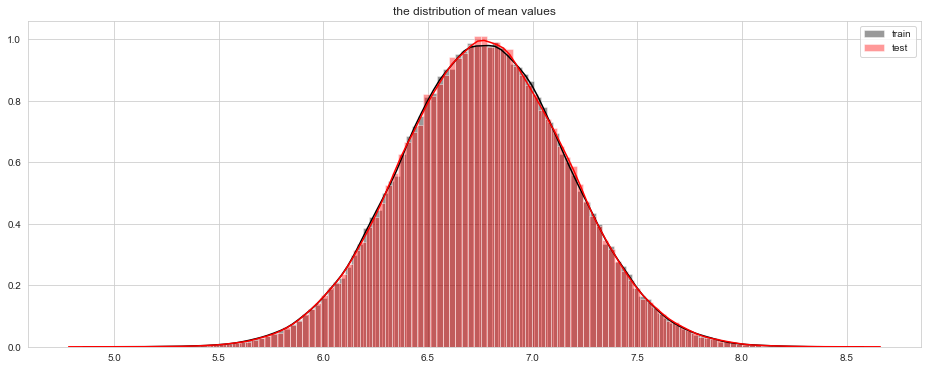

In [50]:
#从上面看traindata和testdata的分布情况基本类似，再可视化一下traindata和testdata的每列数据的平均值和标准差验证一下
plt.figure(figsize=(16,6))
plt.title("the distribution of mean values")
sns.distplot(traindata[features].mean(axis=1),color='black',kde=True,bins=120,label='train')
sns.distplot(testdata[features].mean(axis=1),color='red',kde=True,bins=120,label='test')
plt.legend()
plt.show()

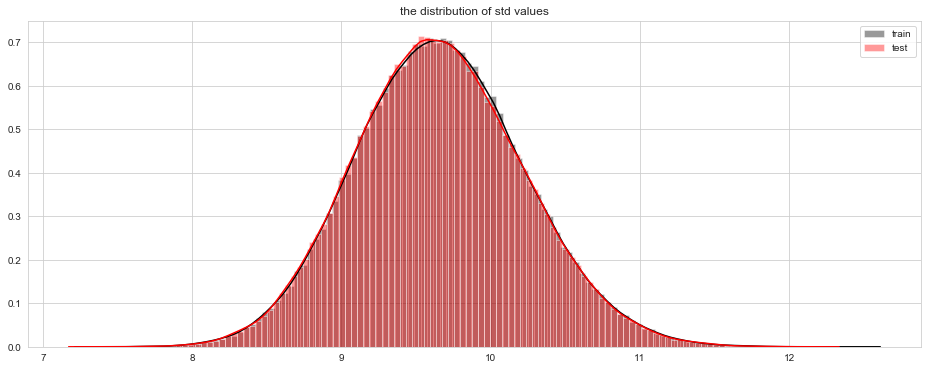

In [51]:
plt.figure(figsize=(16,6))
plt.title("the distribution of std values")
sns.distplot(traindata[features].std(axis=1),color="black",kde=True,bins=120,label="train")
sns.distplot(testdata[features].std(axis=1),color="red",kde=True,bins=120,label="test")
plt.legend()
plt.show()

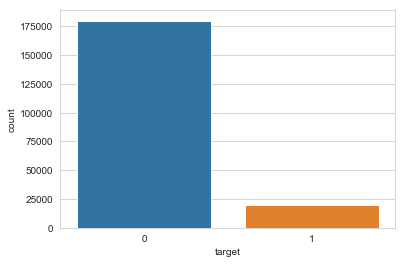

In [52]:
#看一下train目标变量的分布情况,分布不是很均衡,大概是9:1
target = traindata['target']
#traindata.drop(['ID_code','target'],axis=1,inplace=True)
target.value_counts()
sns.countplot(traindata['target'])

<Figure size 432x288 with 0 Axes>

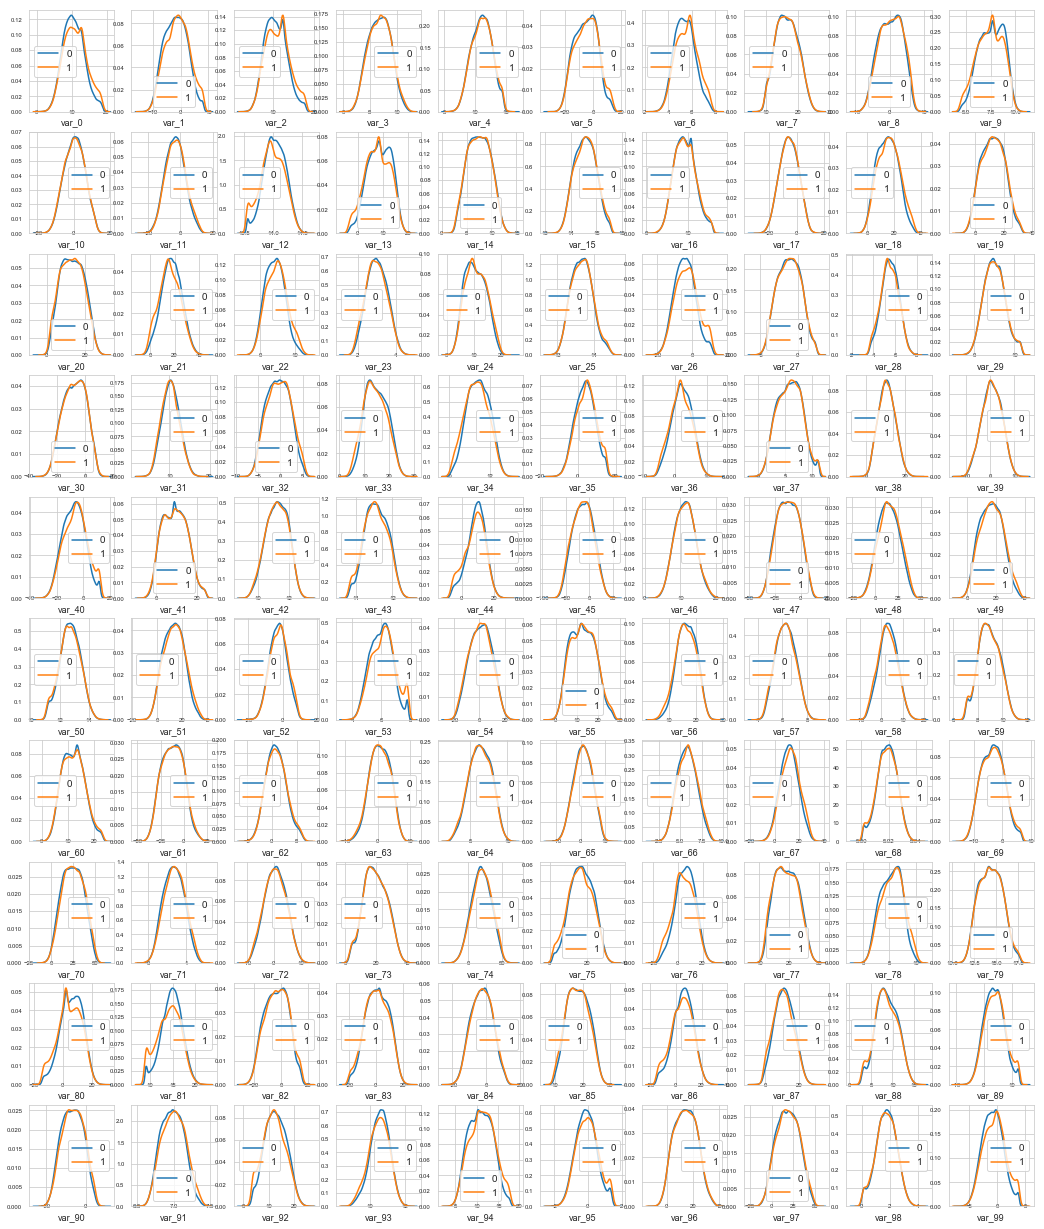

In [58]:
#观察各特征变量在目标变量取值分别为0和1时候的分布情况
#var_0,var_1,var_2,var_6,var_9,var_12,var_13,var_106,var_109,var_139等在目标变量为0和1时分布有些不同

def plot_feature_distribution(df1,df2,label1,label2,features):
    i=0
    sns.set_style("whitegrid")
    plt.figure()
    fig,ax=plt.subplots(10,10,figsize=(18,22))
    
    for feature in features:
        i +=1
        plt.subplot(10,10,i)
        sns.distplot(df1[feature],hist=False,label=label1)
        sns.distplot(df2[feature],hist=False,label=label2)
        plt.xlabel(feature,fontsize=9)
        locs,labels=plt.xticks()
        plt.tick_params(axis='x',which="major",labelsize=6,pad=-6)
        plt.tick_params(axis='y',which='major',labelsize=6)
    plt.show()
t1 = traindata.loc[traindata['target']==0]
t2 = traindata.loc[traindata['target']==1]
features1 = features[0:100]
plot_feature_distribution(t1,t2,'0','1',features1)


<Figure size 432x288 with 0 Axes>

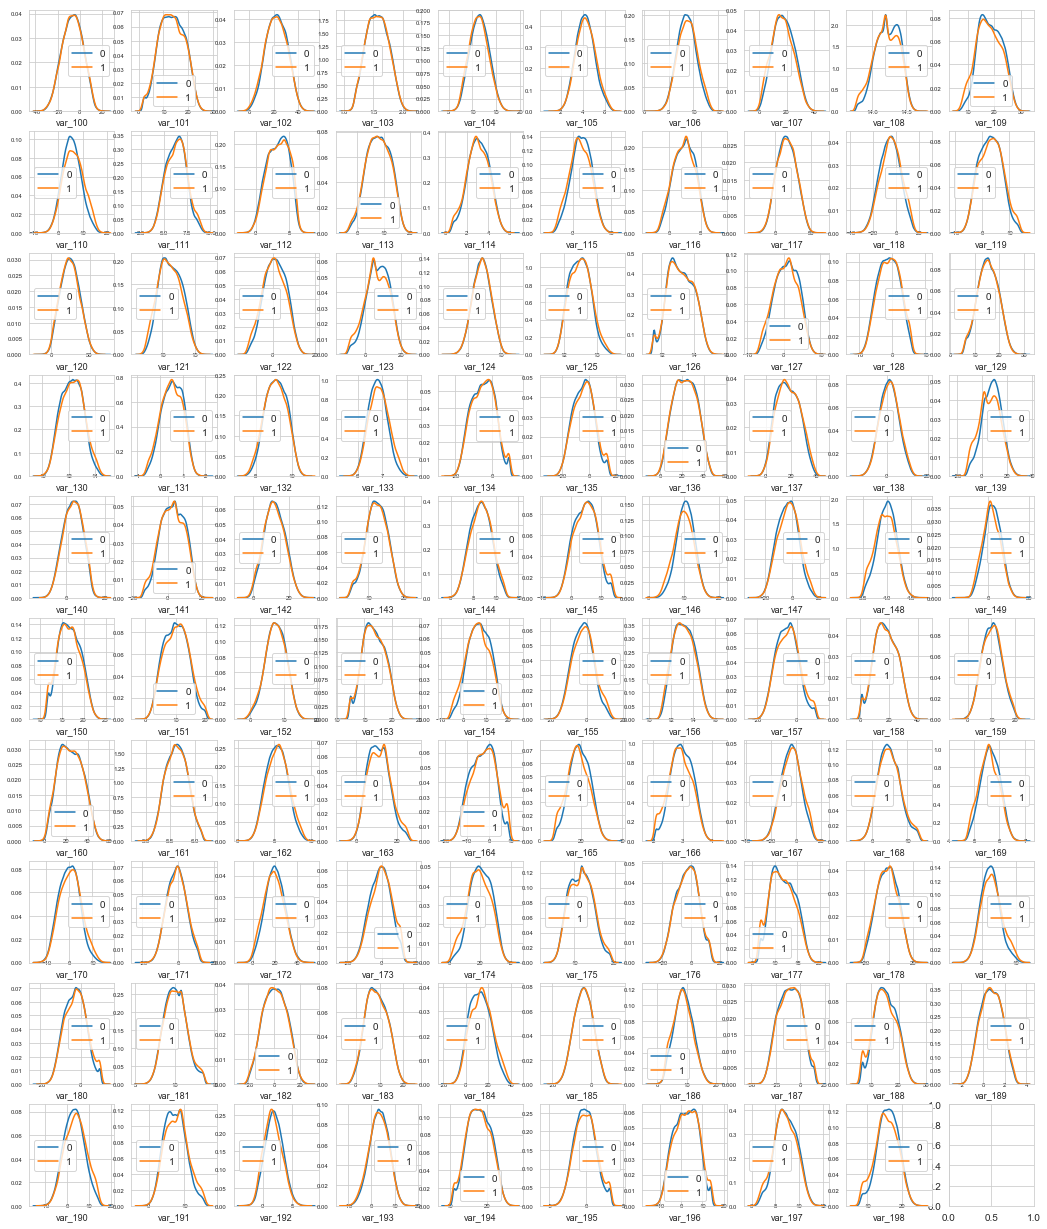

In [59]:
features2 =features[100:199]
plot_feature_distribution(t1,t2,'0','1',features2)

<Figure size 432x288 with 0 Axes>

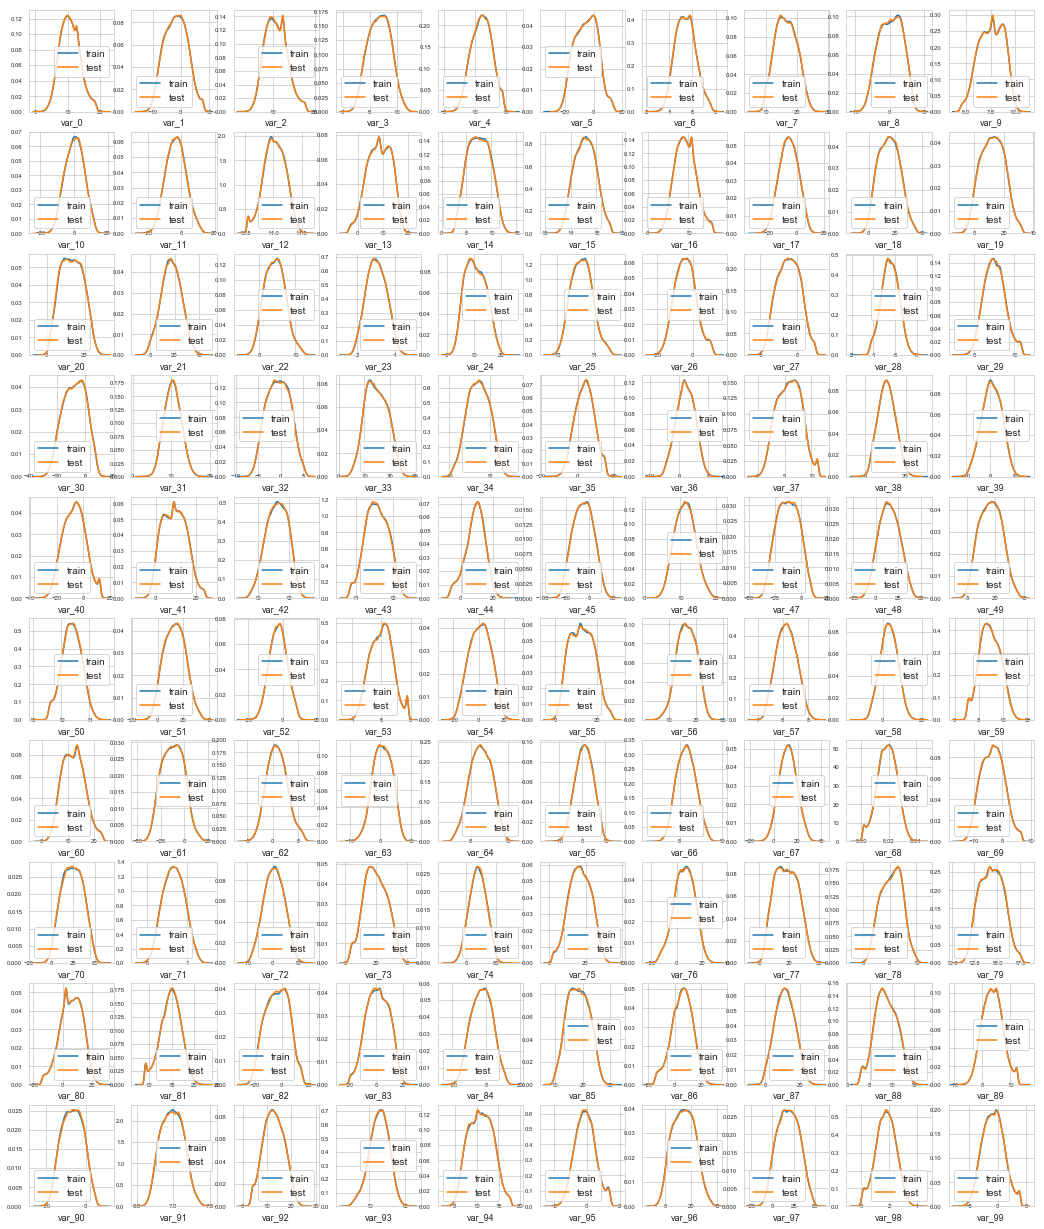

In [60]:
#利用plot_feature_distribution验证各个变量在traindata和testdata上的分布是否一致
features1 = features[0:100]
plot_feature_distribution(traindata,testdata,"train","test",features1)

<Figure size 432x288 with 0 Axes>

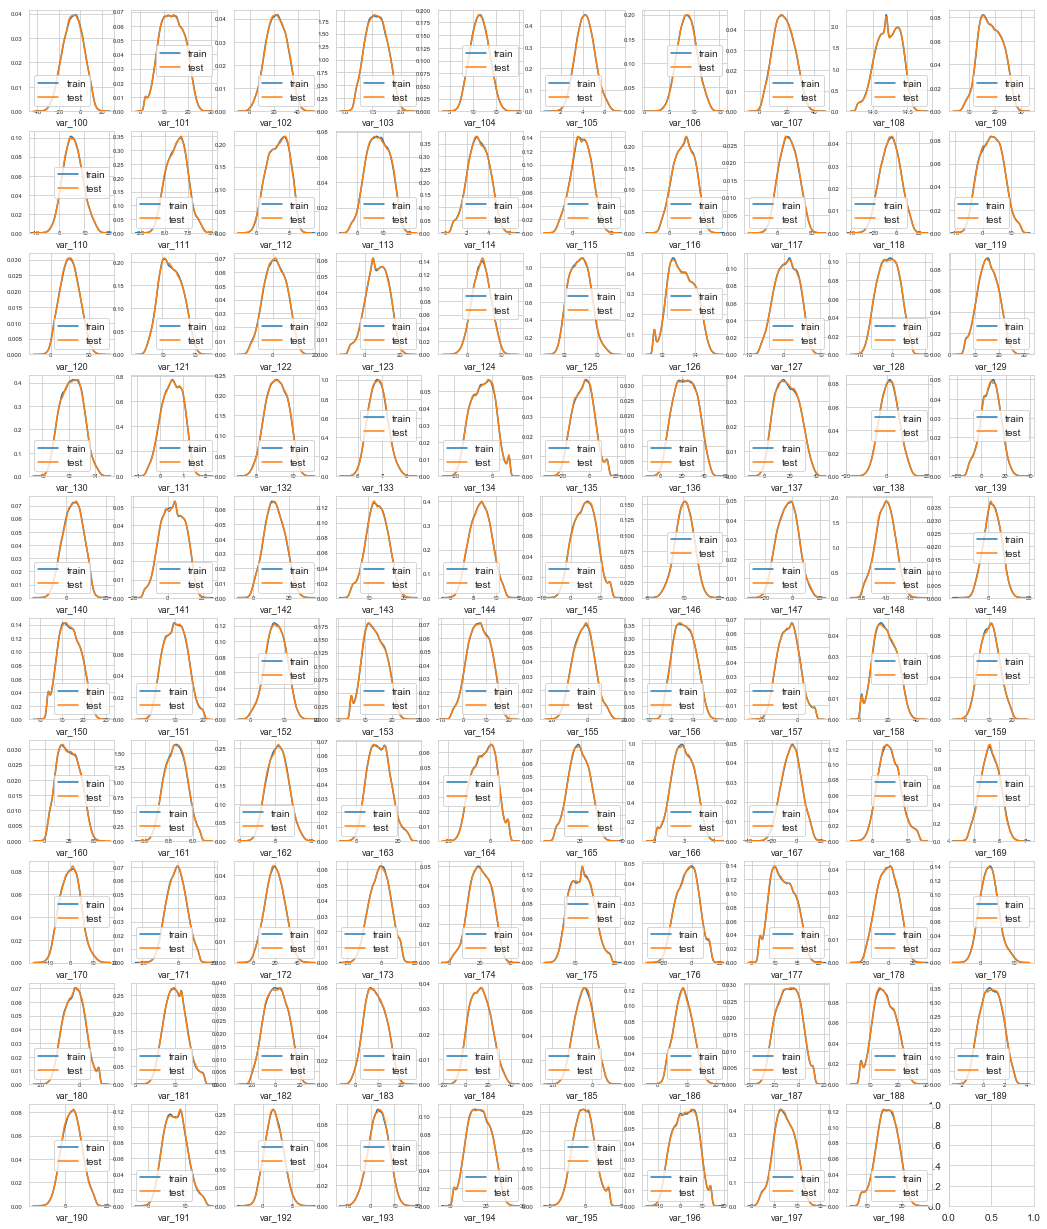

In [62]:
features2 = features[100:199]
plot_feature_distribution(traindata,testdata,"train","test",features2)

In [86]:
#查看各变量之间的相关性
correlations = traindata[features].corr().abs().unstack().sort_values(kind='quicksort').reset_index()
correlations = correlations[correlations['level_0']!=correlations['level_1']]
pd.set_option('precision',10)
pd.set_option('display.float_format',lambda x: '%.10f'%x)
correlations.head()
#可以看出各变量之间的关联性很小

In [96]:
#构造变量，根据现有的各连续变量，构造一下sum,min,max等几个相关变量
for df in [traindata, testdata]:
    df['sum'] = df[features].sum(axis=1)
    df['min'] = df[features].min(axis=1)
    df['max'] = df[features].max(axis=1)
    df['mean'] = df[features].mean(axis=1)
    df['std'] = df[features].std(axis=1)
    df['skew'] = df[features].skew(axis=1)
    df['kurt'] = df[features].kurtosis(axis=1)
    df['med'] = df[features].median(axis=1)

In [128]:
features = [c for c in traindata.columns if c not in ['ID_code','target']]

In [98]:
#利用PCA降维看是否有用
'''from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
train = traindata[features]
test = testdata[features]
pca = PCA(n_components=10,copy=True)
pca_train = pca.fit_transform(train) '''

In [119]:
param = {
    'bagging_freq': 5,
    'bagging_fraction': 0.4,
    'boost_from_average':'false',
    'boost': 'gbdt',
    'feature_fraction': 0.05,
    'learning_rate': 0.01,
    'max_depth': -1,  
    'metric':'auc',
    'min_data_in_leaf': 80,
    'min_sum_hessian_in_leaf': 10.0,
    'num_leaves': 13,
    'num_threads': 8,
    'tree_learner': 'serial',
    'objective': 'binary', 
    'verbosity': 1
}

In [121]:
folds = StratifiedKFold(n_splits=10,shuffle=False,random_state=44000)
oof = np.zeros(len(train))
predictions = np.zeros(len(test))
feature_importance_df = pd.DataFrame()

for fold_,(trn_idx,val_idx) in enumerate(folds.split(train.values,target.values)):
    print("Fold {}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][features],label=target.iloc[trn_idx])
    val_data = lgb.Dataset(train.iloc[val_idx][features],label=target.iloc[val_idx])
    
    num_round = 1000000
    clf = lgb.train(param,trn_data,num_round,valid_sets=[trn_data,val_data],
                    verbose_eval=1000,early_stopping_rounds=3000)
    oof[val_idx] = clf.predict(train.iloc[val_idx][features],
                               num_iteration=clf.best_iteration)
    fold_importance_df = pd.DataFrame()
    fold_importance_df['Feature'] = features
    fold_importance_df['importance'] = clf.feature_importance()
    fold_importance_df['fold'] = fold_+1
    feature_importance_df = pd.concat([feature_importance_df,fold_importance_df],axis=0)
    
    predictions += clf.predict(test[features],num_iteration=clf.best_iteration)/folds.n_splits
    
    print("cv score:{:<8.5f}".format(roc_auc_score(target,oof)))

Fold 0
Training until validation scores don't improve for 3000 rounds.
[1000]	training's auc: 0.89904	valid_1's auc: 0.880364
[2000]	training's auc: 0.911204	valid_1's auc: 0.888868
[3000]	training's auc: 0.91903	valid_1's auc: 0.893151
[4000]	training's auc: 0.924854	valid_1's auc: 0.896012
[5000]	training's auc: 0.929701	valid_1's auc: 0.897714
[6000]	training's auc: 0.933934	valid_1's auc: 0.898494
[7000]	training's auc: 0.93786	valid_1's auc: 0.898994
[8000]	training's auc: 0.941613	valid_1's auc: 0.89928
[9000]	training's auc: 0.945152	valid_1's auc: 0.899671
[10000]	training's auc: 0.948466	valid_1's auc: 0.899878
[11000]	training's auc: 0.951758	valid_1's auc: 0.900177
[12000]	training's auc: 0.954863	valid_1's auc: 0.899992
[13000]	training's auc: 0.957793	valid_1's auc: 0.899881
[14000]	training's auc: 0.96065	valid_1's auc: 0.899628
Early stopping, best iteration is:
[11045]	training's auc: 0.951908	valid_1's auc: 0.900223
cv score:0.50401 
Fold 1
Training until validation sc

[8000]	training's auc: 0.941648	valid_1's auc: 0.900745
[9000]	training's auc: 0.945235	valid_1's auc: 0.900773
[10000]	training's auc: 0.94862	valid_1's auc: 0.900838
[11000]	training's auc: 0.951843	valid_1's auc: 0.900587
[12000]	training's auc: 0.954894	valid_1's auc: 0.900639
Early stopping, best iteration is:
[9691]	training's auc: 0.947612	valid_1's auc: 0.900898
cv score:0.90053 


In [123]:
cols = (feature_importance_df[['Feature','importance']].groupby('Feature').mean().
       sort_values(by='importance',ascending=False)[:150].index)

In [124]:
best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

C:\Users\lu\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


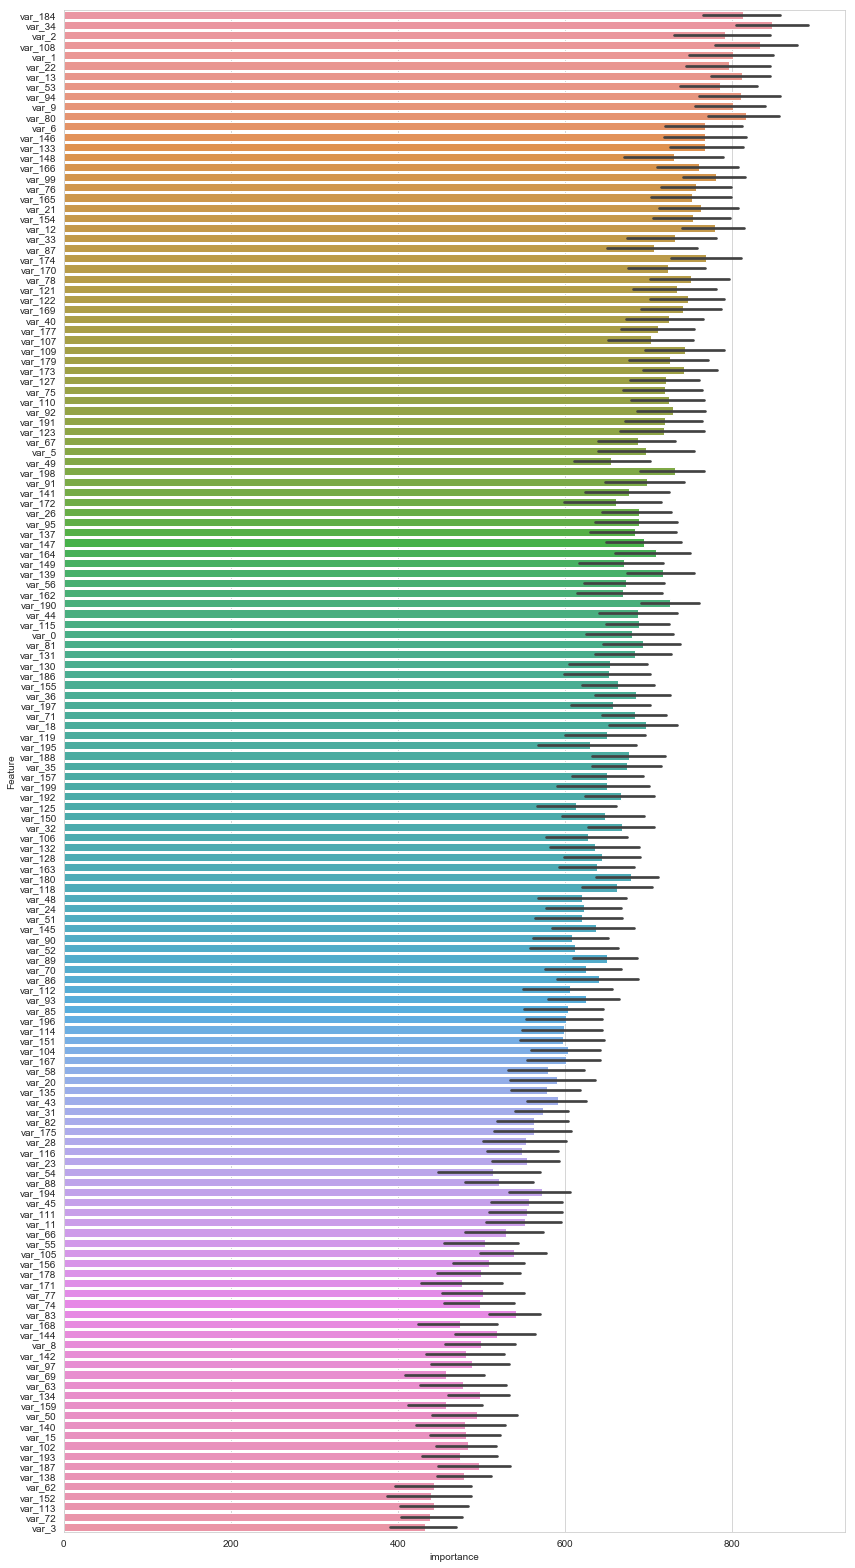

In [125]:
plt.figure(figsize=(14,28))
sns.barplot(x="importance",y='Feature',data=best_features.sort_values(by='importance',ascending=False))

In [127]:
sub_df = pd.DataFrame({'ID_code':testdata['ID_code'].values})
sub_df['target'] = predictions
sub_df.to_csv('submission.csv',index=False)